## Clustering

To determine if the property data has easily-distinguishable groups, I employed two different unsupervised clustering techniques, KMeans and Mean Shift. I first normalized the data and used PCA to reduce the dimensionality down to just two features for easy visualization. I then plotted the changes in distortion as the number of clusters increased in an attempt to use the elbow method to identify the optimal $k$. Next, I took the optimal $k$ from the elbow method and plotted the silhouette coefficients for each cluster. Lastly, I used Mean Shift to attempt to ascertain clusters.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
# Read in the data
df = pd.read_hdf('../data/processed/bexar_true_labels.h5')
df = df.reset_index()
X = df.iloc[:,:-1]
y = df.crim_prop

#### Reduce Dimensionality and Visualize

###### PCA n_componenets=2

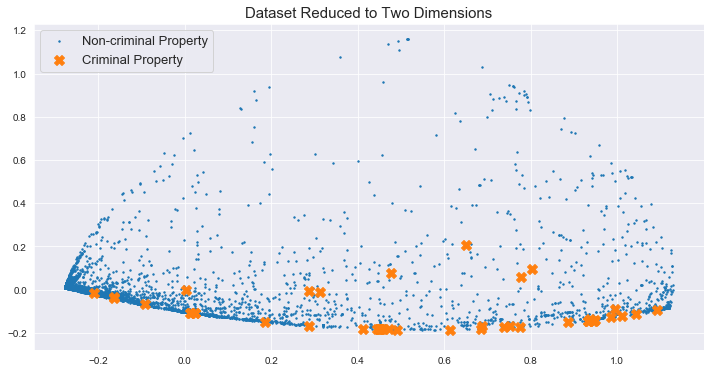

In [3]:
X_norm = normalize(X)
X_pca = PCA(2).fit_transform(X_norm)

markers = [".",'X']
sizes = [8, 100]
plt.figure(figsize=(12,6))

# cycle through each class
for i in range(0,2):
    plt.scatter(
        X_pca[y[y==i].index][:,0], 
        X_pca[y[y==i].index][:,1],
        s=sizes[i],
        marker=markers[i]
    )
plt.title('Dataset Reduced to Two Dimensions',fontsize=15)
plt.legend(('Non-criminal Property','Criminal Property'), loc='upper left',fontsize=13)
plt.show()

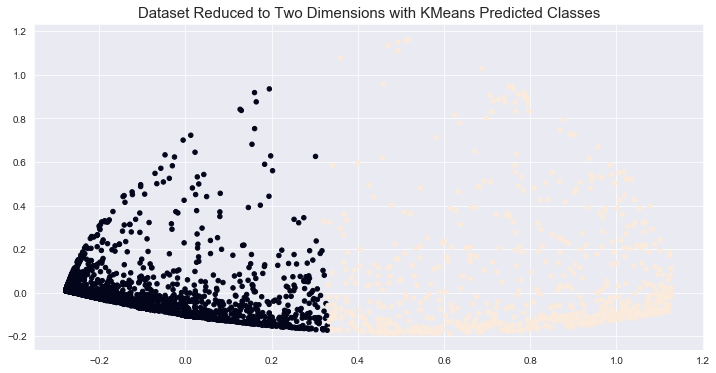

Comparing k-means clusters against the data:
crim_prop   0.0  1.0
row_0               
0          4629   13
1           887   34


In [4]:
# Overlay predicted labels
km = KMeans(
    n_clusters=2,
    init='k-means++',
    random_state=42
)

y_km = km.fit_predict(X_pca)


# Plot the solution.
plt.figure(figsize=(12,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_km,s=20)
plt.title('Dataset Reduced to Two Dimensions with KMeans Predicted Classes',fontsize=15)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_km,y))

Visually, it is immediately apparent why KMeans is correctly identifying 34 of 47 properties. Higher dimensions may do a better job of capturing variance in the data.

###### PCA to higher dimensions

In [5]:
def pca_kmeans(X_norm, n_components):
    # produce KMeans crosstabs for dataset reduced to n dimensions
    for i in n_components:    

        X_pca = PCA(n_components=i)
        
        y_km = km.fit_predict(X_pca.fit_transform(X_norm))
        variance_sum = X_pca.explained_variance_.sum()
        print("Crosstab for {} components".format(i),'\n')
        print("Variance explained:",variance_sum)
        print(pd.crosstab(y_km,y),'\n','###################')

In [6]:
X_norm = normalize(X)
dimensions = range(2,7)
pca_kmeans(X_norm,dimensions)

Crosstab for 2 components 

Variance explained: 0.1754528317945823
crim_prop   0.0  1.0
row_0               
0          4629   13
1           887   34 
 ###################
Crosstab for 3 components 

Variance explained: 0.18160498351805504
crim_prop   0.0  1.0
row_0               
0          4629   13
1           887   34 
 ###################
Crosstab for 4 components 

Variance explained: 0.1816142727548439
crim_prop   0.0  1.0
row_0               
0          4629   13
1           887   34 
 ###################
Crosstab for 5 components 

Variance explained: 0.18161644309895747
crim_prop   0.0  1.0
row_0               
0          4629   13
1           887   34 
 ###################
Crosstab for 6 components 

Variance explained: 0.18161647447580895
crim_prop   0.0  1.0
row_0               
0          4629   13
1           887   34 
 ###################


It appears that with more components, performance does not improve. Additionally, there is virtually no increase in the amount of variance that is explained from 2 components to 6 components.

#### Elbow Method with Distortion Plot

The elbow method may reveal the optimal number of clusters. Distortion will decrease as $k$ increases as the samples will be closer to their centroids. Therefore, identifying the value of $k$ where the rate of change of distortion begins to decrease more slowly will allow for an estimation of the optimal $k$.

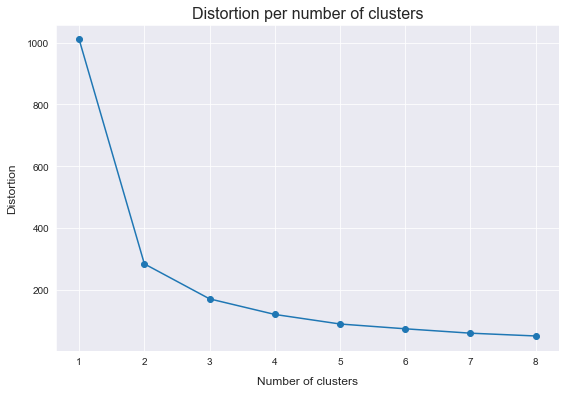

In [7]:
skip = 0
if skip == 0:
    distortions = []
    for i in range(1, 9):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    random_state=3)
        km.fit(X_norm)
        distortions.append(km.inertia_)
        
    plt.figure(figsize=(9,6))
    plt.plot(range(1, 9), distortions, marker='o')
    plt.xlabel('Number of clusters',labelpad=10,fontsize=12)
    plt.ylabel('Distortion',labelpad=10,fontsize=12)
    plt.title('Distortion per number of clusters',fontsize=16)
    plt.show()

Based on the change in the slope of the above plot, it appears that k=2 is the optimal number of clusters.

#### Silhouette Plots

The mean of the silhouette coefficients for each cluster will provide an idea of how similar the datapoins in each cluster are.

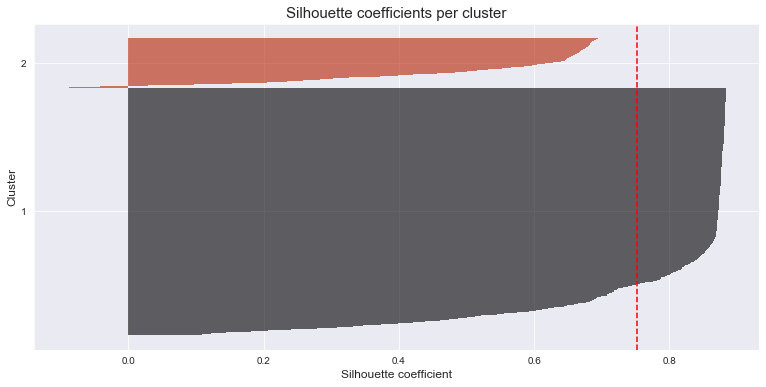

In [8]:
plt.figure(figsize=(13,6))
km = KMeans(n_clusters=2,
            init='k-means++',
            random_state=3)
y_km = km.fit_predict(X_norm)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X_norm, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, j in enumerate(cluster_labels):
    j_silhouette_vals = silhouette_vals[y_km == j]
    j_silhouette_vals.sort()
    y_ax_upper += len(j_silhouette_vals)
    color = cm.gnuplot(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             j_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color,
             alpha=0.6
            )
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(j_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster',fontsize=12)
plt.xlabel('Silhouette coefficient',fontsize=12)
plt.title('Silhouette coefficients per cluster',fontsize=15)
plt.show()

This plot shows that each cluster appears to be made up of relatively similar data points, because each cluster's mean silhouette coefficient is well above 0. However, it is apparent that cluster 1 is far larger than cluster 2 and has a higher average silhouette coefficient. This means the clustering is likely suboptimal.

#### Mean Shift

With no previous assumptions made about the number of clusters, Mean Shift may provide better clustering.

In [9]:
# Bandwidth doesn't scale well, so I will manually gridsearch
bandwidths = [0.1,0.2,0.3,0.5,0.75,1,2]

for i in bandwidths:
    ms = MeanShift(bandwidth=i, bin_seeding=True)
    ms.fit(X_norm)

    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    n_clusters_ = len(np.unique(labels))
    print('Number of estimated clusters: {0} with bandwidth={1}'.format(n_clusters_,i))

Number of estimated clusters: 41 with bandwidth=0.1
Number of estimated clusters: 10 with bandwidth=0.2
Number of estimated clusters: 4 with bandwidth=0.3
Number of estimated clusters: 2 with bandwidth=0.5
Number of estimated clusters: 1 with bandwidth=0.75
Number of estimated clusters: 1 with bandwidth=1
Number of estimated clusters: 1 with bandwidth=2


Higher bandwidths "smooth out" more potential clusters. As the bandwidth increases, the number of clusters Mean Shift detects drops rapidly.

#### Final Notes

- Reducing the dimensionality of the data did not reveal clean clusters. 
- Although plotting the change in distortion over an increasing number of clusters would indicate k=2 may be optimal, the plot of each cluster's silhouette coefficients indicates that they aren't the cleanest clusters. One cluster is far larger and has a higher silhouette coefficient.